## 1. Comparing DHT and DHT-DIMA models

Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running 

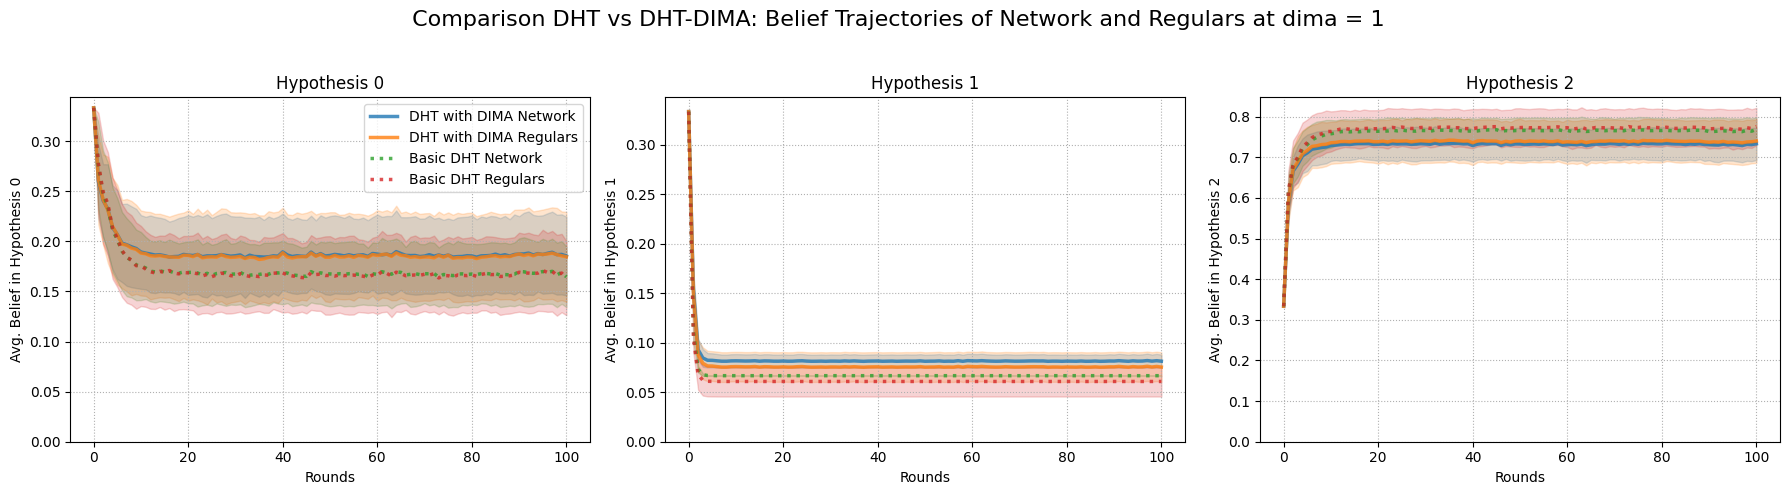

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
from dhtDIMA import DHTwdDIMA
from dht import BasicDHT


def shared_simulation(n_runs = 5):
    dima_traj_list = []
    dht_traj_list = []
    # SHARED SETUP
    for i in range(n_runs):
        N, M, d_feature = 100, 3, 5
        T = 100
        random.seed(10 +i)
        np.random.seed(10 + i)
    
        # Thematic setup
        themes = {"politics": [0, 1], "sports": [2, 3]}
        normative_groups = {
            "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
            "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
        }
    
        # Graph and weight matrix
        G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
        W = nx.to_numpy_array(G)
        W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
    
        # Features and distributions
        agent_features = np.random.rand(N, d_feature)
        distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
    
        # Agent roles
        conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
        remaining_idx = list(set(range(N)) - set(conspirators_idx))
        debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
    
        # DHT with DIMA Simulation
        print("Running DHTwdDIMA simulation...")
        sim_dima = DHTwdDIMA(N, M, G, W, distributions, agent_features, themes, normative_groups,
                             conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=1, seed=10 + i)
        
        traj_dima = sim_dima.run(T)
        dima_traj_list.append(traj_dima)
        
    
        # Basic DHT Simulation
        print("Running Basic DHT simulation...")
        sim_basic = BasicDHT(N, M, W, distributions, conspirators_idx.tolist(), debunkers_idx.tolist(), seed=10 + i)
        traj_basic = sim_basic.run(T)
        dht_traj_list.append(traj_basic)
         
    
    # Convert to numpy arrays for easy averaging
    dima_traj_array = np.array(dima_traj_list)  # shape: (n_runs, T+1, N, M)
    dht_traj_array = np.array(dht_traj_list)    # shape: (n_runs, T+1, N, M)

    idx = [0, 1, 2]
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Use indices from the last run just for "regulars"
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    # print(dima_traj_array.shape)
    # return 0

    for j, i in enumerate(idx):
        # Mean over runs, then mean over regular agents
        dima_network_curve = dima_traj_array[:, :, :, i].mean(axis=(0, 2))
        dima_regular_curve = dima_traj_array[:, :, regulars, i].mean(axis=(0, 2))
        
        dht_network_curve = dht_traj_array[:, :, :, i].mean(axis=(0, 2))
        dht_regular_curve = dht_traj_array[:, :, regulars,  i].mean(axis=(0, 2))
        
        # --- Standard deviations (across runs) ---
        dima_network_std = dima_traj_array[:, :, :, i].mean(axis=2).std(axis=0)
        dima_regular_std = dima_traj_array[:, :, regulars, i].mean(axis=2).std(axis=0)
        dht_network_std  = dht_traj_array[:, :, :, i].mean(axis=2).std(axis=0)
        dht_regular_std  = dht_traj_array[:, :, regulars, i].mean(axis=2).std(axis=0)
        
        ax = axes[j]
        rounds = np.arange(len(dima_network_curve))

        # --- Plot mean curves ---
        l1, = ax.plot(rounds, dima_network_curve, label='DHT with DIMA Network', linewidth=2.5, alpha=0.8)
        l2, = ax.plot(rounds, dima_regular_curve, label='DHT with DIMA Regulars', linewidth=2.5, alpha=0.8)
        l3, = ax.plot(rounds, dht_network_curve, label='Basic DHT Network', linewidth=2.5, linestyle=':', alpha=0.8)
        l4, = ax.plot(rounds, dht_regular_curve, label='Basic DHT Regulars', linewidth=2.5, linestyle=':', alpha=0.8)

        # --- Shaded error bands (mean ± std) ---
        ax.fill_between(rounds, dima_network_curve - dima_network_std, dima_network_curve + dima_network_std,
                        color=l1.get_color(), alpha=0.2)
        ax.fill_between(rounds, dima_regular_curve - dima_regular_std, dima_regular_curve + dima_regular_std,
                        color=l2.get_color(), alpha=0.2)
        ax.fill_between(rounds, dht_network_curve - dht_network_std, dht_network_curve + dht_network_std,
                        color=l3.get_color(), alpha=0.2)
        ax.fill_between(rounds, dht_regular_curve - dht_regular_std, dht_regular_curve + dht_regular_std,
                        color=l4.get_color(), alpha=0.2)
        
        
        
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {i}")
        ax.set_title(f"Hypothesis {i}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f" Comparison DHT vs DHT-DIMA: Belief Trajectories of Network and Regulars at dima = 1", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Belief_trajectory_network_std.pdf")
    plt.show()

shared_simulation(20)


## 2. Impact of Identity Strength

Running DHTwdDIMA simulation (beta=0.1, run 1/20)...
Running DHTwdDIMA simulation (beta=0.1, run 2/20)...
Running DHTwdDIMA simulation (beta=0.1, run 3/20)...
Running DHTwdDIMA simulation (beta=0.1, run 4/20)...
Running DHTwdDIMA simulation (beta=0.1, run 5/20)...
Running DHTwdDIMA simulation (beta=0.1, run 6/20)...
Running DHTwdDIMA simulation (beta=0.1, run 7/20)...
Running DHTwdDIMA simulation (beta=0.1, run 8/20)...
Running DHTwdDIMA simulation (beta=0.1, run 9/20)...
Running DHTwdDIMA simulation (beta=0.1, run 10/20)...
Running DHTwdDIMA simulation (beta=0.1, run 11/20)...
Running DHTwdDIMA simulation (beta=0.1, run 12/20)...
Running DHTwdDIMA simulation (beta=0.1, run 13/20)...
Running DHTwdDIMA simulation (beta=0.1, run 14/20)...
Running DHTwdDIMA simulation (beta=0.1, run 15/20)...
Running DHTwdDIMA simulation (beta=0.1, run 16/20)...
Running DHTwdDIMA simulation (beta=0.1, run 17/20)...
Running DHTwdDIMA simulation (beta=0.1, run 18/20)...
Running DHTwdDIMA simulation (beta=0.

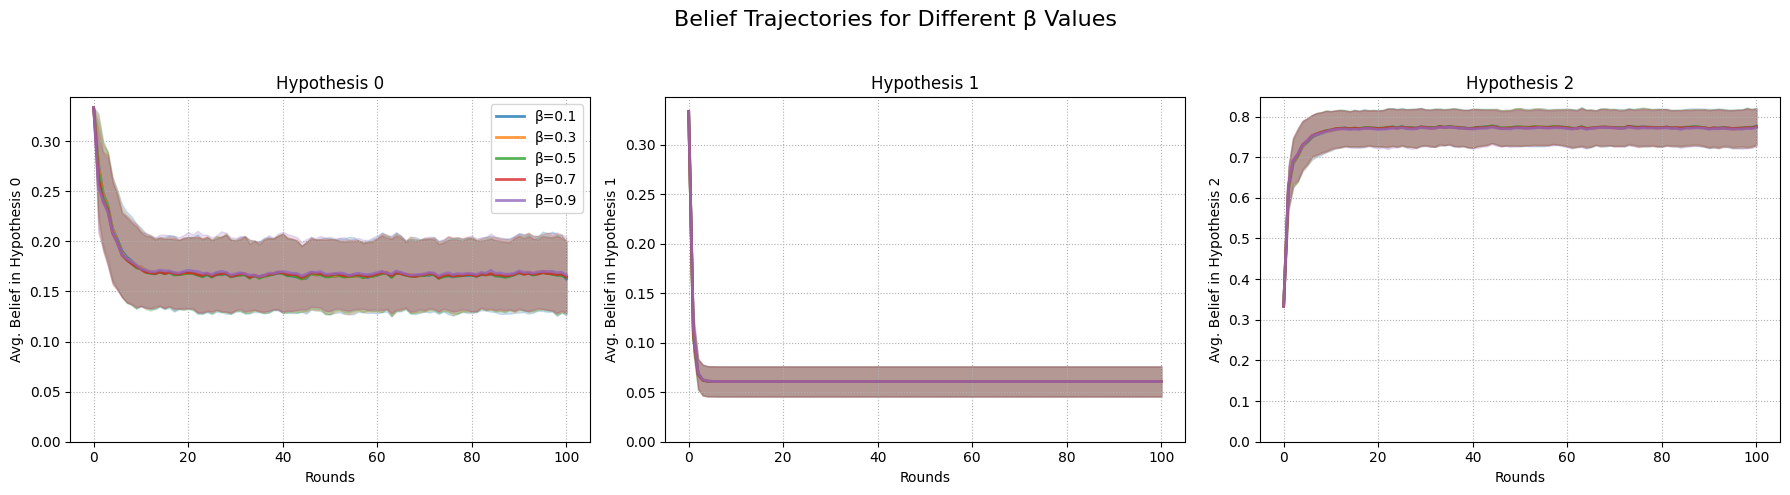

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
from dhtDIMA import DHTwdDIMA

def shared_simulation(n_runs=1):
    dima_beta_list = [0.1, 0.3, 0.5, 0.7, 0.9]
    dima_beta_dict = {}
    
    for dima_beta in dima_beta_list:
        dima_temp = []
        dht_traj_list =[]
        for i in range(n_runs):
            N, M, d_feature = 100, 3, 5
            T = 100
            random.seed(10 + i)
            np.random.seed(10 + i)
        
            themes = {"politics": [0, 1], "sports": [2, 3]}
            normative_groups = {
                "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
                "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
            }
        
            G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
            W = nx.to_numpy_array(G)
            W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
        
            agent_features = np.random.rand(N, d_feature)
            distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
        
            conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
            remaining_idx = list(set(range(N)) - set(conspirators_idx))
            debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
        
            print(f"Running DHTwdDIMA simulation (beta={dima_beta}, run {i+1}/{n_runs})...")
            sim_dima = DHTwdDIMA(N, M, G, W, distributions, agent_features, themes, normative_groups,
                                 conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=dima_beta, seed=10 + i)
            
            traj_dima = sim_dima.run(T)  # shape: (T+1, N, M)
            dima_temp.append(traj_dima)
            
            # sim_basic = BasicDHT(N, M, W, distributions, conspirators_idx.tolist(), debunkers_idx.tolist())
            # traj_basic = sim_basic.run(T)
            # dht_traj_list.append(traj_basic)
        
        # store all runs for this beta
        dima_beta_dict[dima_beta] = np.array(dima_temp)
        # dima_beta_dict["dht"] = np.array(dht_traj_list) # shape: (n_runs, T+1, N, M)
    
    # ---- Plotting ----
    idx = [0, 1, 2]  # hypotheses to plot
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Using "regulars" from the last run of last beta for index reference
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, hyp_idx in enumerate(idx):
        ax = axes[j]
        for beta in dima_beta_list:
            traj_array = dima_beta_dict[beta]  # shape: (n_runs, T+1, N, M)
            # mean over runs and over agents (regulars only)
            mean_curve = traj_array[:, :, regulars, hyp_idx].mean(axis=(0, 2))
            rounds = np.arange(len(mean_curve))
            std = traj_array[:, :, regulars, hyp_idx].mean(axis=2).std(axis=0)
            l1, = ax.plot(rounds, mean_curve, label=f"β={beta}", linewidth=2.0,  alpha=0.8)
            ax.fill_between(rounds, mean_curve - std, mean_curve + std,
                        color=l1.get_color(), alpha=0.2)
        
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {hyp_idx}")
        ax.set_title(f"Hypothesis {hyp_idx}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Belief Trajectories for Different β Values", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Belief Trajectories for Different β Values.pdf")
    plt.show()

shared_simulation(20)


## 3. Sensitivity Analysis

Running DHTwdDIMA (N=200, β=0.9, run 1/1)...
Running DHTwdDIMA (N=300, β=0.9, run 1/1)...
Running DHTwdDIMA (N=500, β=0.9, run 1/1)...
Running DHTwdDIMA (N=200, β=1, run 1/1)...
Running DHTwdDIMA (N=300, β=1, run 1/1)...
Running DHTwdDIMA (N=500, β=1, run 1/1)...


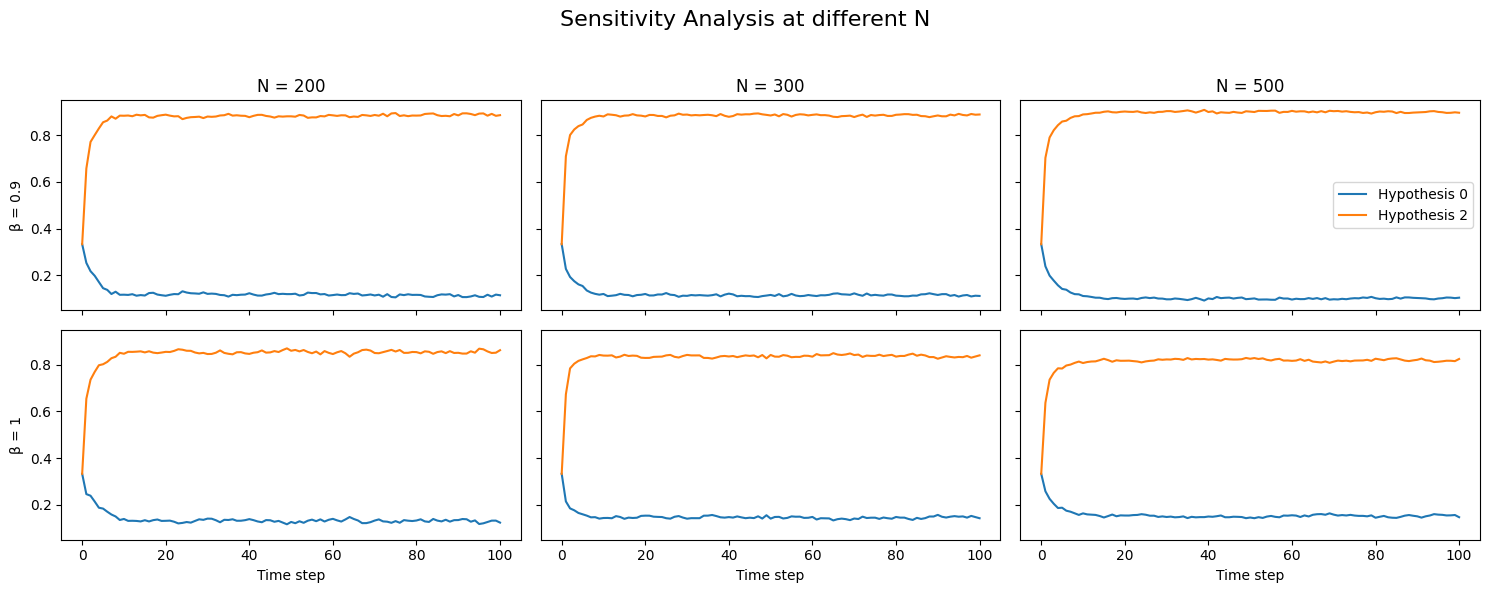

In [7]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
from dhtDIMA import DHTwdDIMA


def shared_simulation(n_runs=1):
    dima_beta_list = [0.9, 1]
    network_sizes = [200, 300, 500]
    
    # Store: network_dict[n_agents][beta] = dict with per-run data and regulars list
    dima_beta_dict = {}
    
    for dima_beta in dima_beta_list :
        network_dict = {}
        for n_agents in network_sizes:
            run_data = []
            run_regulars = []
            
            for i in range(n_runs):
                N, M, d_feature = n_agents, 3, 5
                T = 100
                random.seed(10 + i)
                np.random.seed(10 + i)
            
                themes = {"politics": [0, 1], "sports": [2, 3]}
                normative_groups = {
                    "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
                    "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
                }
            
                G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
                W = nx.to_numpy_array(G)
                W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
            
                agent_features = np.random.rand(N, d_feature)
                distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
            
                conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
                remaining_idx = list(set(range(N)) - set(conspirators_idx))
                debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
                regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))
            
                print(f"Running DHTwdDIMA (N={n_agents}, β={dima_beta}, run {i+1}/{n_runs})...")
                sim_dima = DHTwdDIMA(
                    N, M, G, W, distributions, agent_features, themes, normative_groups,
                    conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=dima_beta
                )
                
                traj_dima = sim_dima.run(T)  # shape: (T+1, N, M)
                run_data.append(traj_dima)
                run_regulars.append(regulars)
            
            network_dict[n_agents] = {
                "data": np.array(run_data),       # shape: (n_runs, T+1, N, M)
                "regulars_per_run": run_regulars  # list of lists of indices
            }
        
        dima_beta_dict[dima_beta] = network_dict
    return dima_beta_dict
    


def plot_shared_simulation_results(results_dict):
    """
    results_dict: Output of shared_simulation (dima_beta_dict)
                  Structure: results_dict[beta][n_agents]['data'] = (n_runs, T+1, N, M)
                              results_dict[beta][n_agents]['regulars_per_run'] = list of regular agent indices
    """
    dima_beta_list = sorted(results_dict.keys())
    network_sizes = sorted(next(iter(results_dict.values())).keys())
    
    fig, axes = plt.subplots(len(dima_beta_list), len(network_sizes), figsize=(15, 6), sharex=True, sharey=True)
    
    for row_idx, beta in enumerate(dima_beta_list):
        for col_idx, n_agents in enumerate(network_sizes):
            ax = axes[row_idx, col_idx] if len(dima_beta_list) > 1 else axes[col_idx]
            
            sim_data = results_dict[beta][n_agents]["data"]  # shape: (n_runs, T+1, N, M)
            regulars_runs = results_dict[beta][n_agents]["regulars_per_run"]
            
            # Average over runs, then average over regular agents
            T_plus_1, M = sim_data.shape[1], sim_data.shape[-1]
            mean_hypothesis = np.zeros((T_plus_1, 2))  # only hyp 0 and 2
            
            for run_idx in range(sim_data.shape[0]):
                traj = sim_data[run_idx]  # (T+1, N, M)
                regulars = regulars_runs[run_idx]
                mean_hypothesis[:, 0] += traj[:, regulars, 0].mean(axis=1)  # hyp 0
                mean_hypothesis[:, 1] += traj[:, regulars, 2].mean(axis=1)  # hyp 2
            
            mean_hypothesis /= sim_data.shape[0]
            
            ax.plot(range(T_plus_1), mean_hypothesis[:, 0], label="Hypothesis 0")
            ax.plot(range(T_plus_1), mean_hypothesis[:, 1], label="Hypothesis 2")
            
            if row_idx == 0:
                ax.set_title(f"N = {n_agents}")
            if col_idx == 0:
                ax.set_ylabel(f"β = {beta}")
            
            if row_idx == len(dima_beta_list) - 1:
                ax.set_xlabel("Time step")
            
            if row_idx == 0 and col_idx == len(network_sizes) - 1:
                ax.legend()
    
    plt.tight_layout()
    fig.suptitle(f"Sensitivity Analysis at different N", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Sensitivity Analysis at different N.pdf")
    plt.show()


result_dict = shared_simulation()
plot_shared_simulation_results(result_dict)


## 4. Conspirator size effects

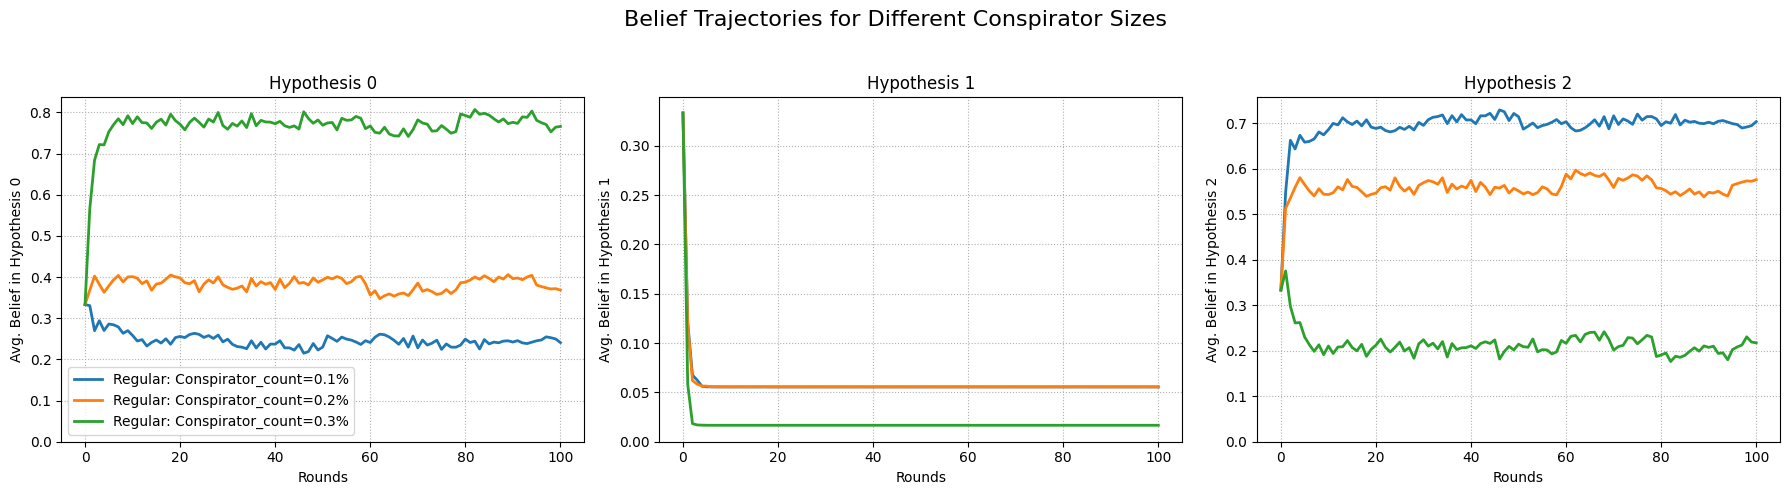

In [6]:
def shared_simulation(n_runs=1):

    conspirator_size  = [0.10, 0.20, 0.30]
    
    # Store: network_dict[n_agents][beta] = dict with per-run data and regulars list
    conspirator_dict = {} 
    
    for cons_size  in conspirator_size :
        run_data = []
        run_regulars = []
           
        for i in range(n_runs):
            N, M, d_feature = 100, 3, 5
            T = 100
            random.seed(10 + i)
            np.random.seed(10 + i)
        
            themes = {"politics": [0, 1], "sports": [2, 3]}
            normative_groups = {
                "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
                "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
            }
        
            G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
            W = nx.to_numpy_array(G)
            W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
        
            agent_features = np.random.rand(N, d_feature)
            distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
        
            conspirators_idx = np.random.choice(N, size=int(cons_size*N), replace=False)
            remaining_idx = list(set(range(N)) - set(conspirators_idx))
            debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
            regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))
        

            sim_dima = DHTwdDIMA(
                N, M, G, W, distributions, agent_features, themes, normative_groups,
                conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=1.0, seed=10+i
            )
            
            traj_dima = sim_dima.run(T)  # shape: (T+1, N, M)
            run_data.append(traj_dima)
            run_regulars.append(regulars)
        
        conspirator_dict[cons_size] = {
            "data": np.array(run_data),       # shape: (n_runs, T+1, N, M)
            "regulars_per_run": run_regulars  # list of lists of indices
        }
    
        # ---- Plotting ----
    idx = [0, 1, 2]  # hypotheses to plot
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Using "regulars" from the last run of last beta for index reference
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, hyp_idx in enumerate(idx):
        ax = axes[j]
        for cons_size in conspirator_dict.keys():
            traj_array = conspirator_dict[cons_size]["data"] # shape: (n_runs, T+1, N, M)
            # mean over runs and over agents (regulars only)
            mean_curve_regulars = traj_array[:, :, regulars, hyp_idx].mean(axis=(0, 2))
            ax.plot(mean_curve_regulars, label=f"Regular: Conspirator_count={cons_size}%", linewidth=2.0)
            
        
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {hyp_idx}")
        ax.set_title(f"Hypothesis {hyp_idx}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Belief Trajectories for Different Conspirator Sizes", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Belief Trajectories for Different Conspirator Sizes.pdf")
    plt.show()

shared_simulation()
    

## 5. Debunker size effects

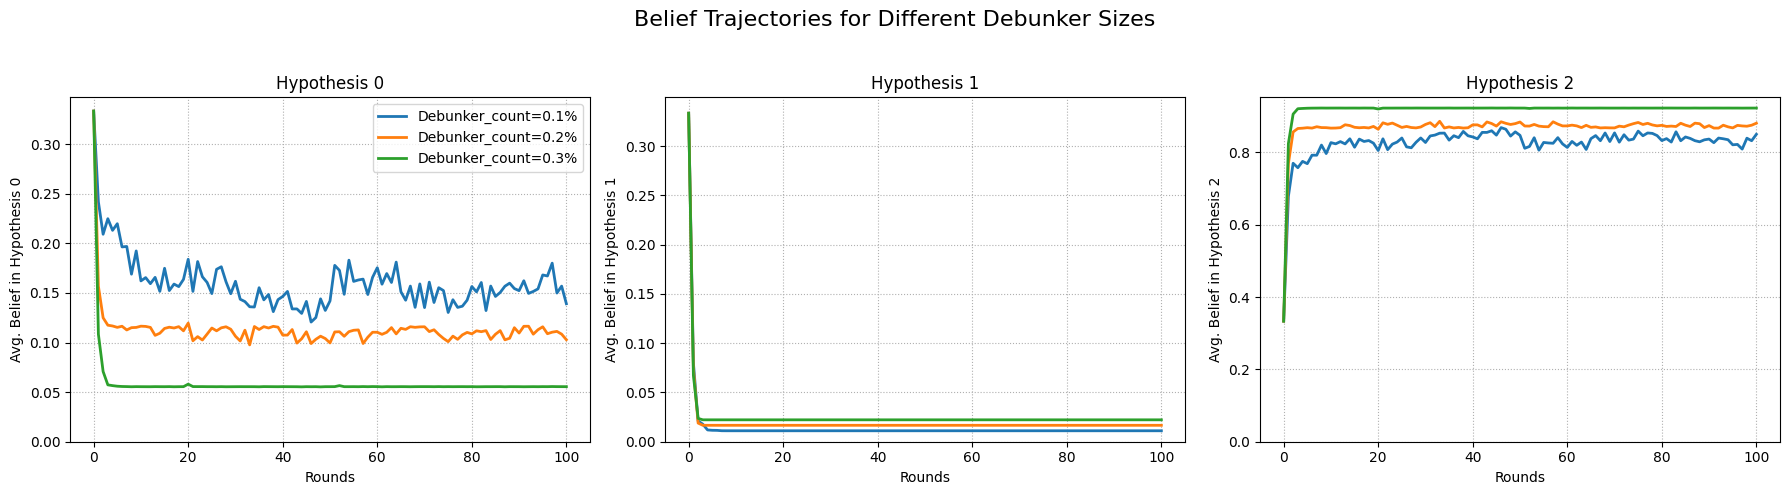

In [5]:
def shared_simulation(n_runs=1):

    Debunker_size  = [0.10, 0.20, 0.30]
    
    # Store: network_dict[n_agents][beta] = dict with per-run data and regulars list
    debunker_dict = {} 
    
    for debs_size  in Debunker_size :
        run_data = []
        run_regulars = []
           
        for i in range(n_runs):
            N, M, d_feature = 100, 3, 5
            T = 100
            random.seed(10 + i)
            np.random.seed(10 + i)
        
            themes = {"politics": [0, 1], "sports": [2, 3]}
            normative_groups = {
                "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
                "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
            }
        
            G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
            W = nx.to_numpy_array(G)
            W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
        
            agent_features = np.random.rand(N, d_feature)
            distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
        
            conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
            remaining_idx = list(set(range(N)) - set(conspirators_idx))
            debunkers_idx = np.random.choice(remaining_idx, size=int(debs_size*N), replace=False)
            regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))
        

            sim_dima = DHTwdDIMA(
                N, M, G, W, distributions, agent_features, themes, normative_groups,
                conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=1, seed=10+i
            )
            
            traj_dima = sim_dima.run(T)  # shape: (T+1, N, M)
            run_data.append(traj_dima)
            run_regulars.append(regulars)
        
        debunker_dict[debs_size] = {
            "data": np.array(run_data),       # shape: (n_runs, T+1, N, M)
            "regulars_per_run": run_regulars  # list of lists of indices
        }
    
        # ---- Plotting ----
    idx = [0, 1, 2]  # hypotheses to plot
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Using "regulars" from the last run of last beta for index reference
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, hyp_idx in enumerate(idx):
        ax = axes[j]
        for debs_size in debunker_dict.keys():
            traj_array = debunker_dict[debs_size]["data"] # shape: (n_runs, T+1, N, M)
            # mean over runs and over agents (regulars only)
            mean_curve = traj_array[:, :, regulars, hyp_idx].mean(axis=(0, 2))
            ax.plot(mean_curve, label=f"Debunker_count={debs_size}%", linewidth=2.0)
        
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {hyp_idx}")
        ax.set_title(f"Hypothesis {hyp_idx}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Belief Trajectories for Different Debunker Sizes", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Belief Trajectories for Different Debunker Sizes.pdf")
    plt.show()

shared_simulation()
    

## 6. Network structure effects

Run:  0
Run:  0
Run:  0


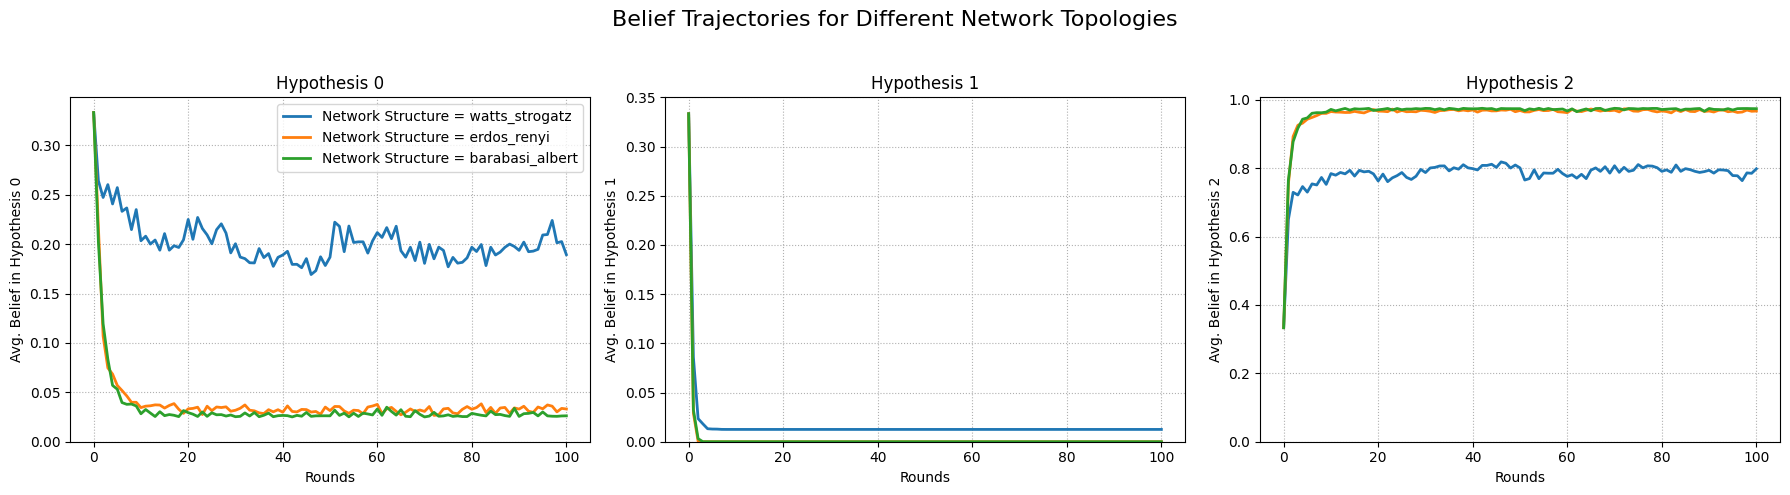

In [4]:
def shared_simulation(n_runs=1):

    Network_strcture  = ['watts_strogatz', 'erdos_renyi', 'barabasi_albert']
    
    # Store: network_dict[n_agents][beta] = dict with per-run data and regulars list
    Network_strcture_dict = {} 
    
    for ns  in Network_strcture :
        run_data = []
        run_regulars = []
           
        for i in range(n_runs):
            print("Run: ", i)
            N, M, d_feature = 100, 3, 5
            T = 100
            random.seed(10 + i)
            np.random.seed(10 + i)
        
            themes = {"politics": [0, 1], "sports": [2, 3]}
            normative_groups = {
                "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
                "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
            }
            if ns == "watts_strogatz":
                G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
            elif ns == "erdos_renyi":
                G = nx.erdos_renyi_graph(n=N, p=0.1, seed=10 )
            else:
                G = nx.barabasi_albert_graph(N, m=4, seed =10)
            W = nx.to_numpy_array(G)
            W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
        
            agent_features = np.random.rand(N, d_feature)
            distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
        
            conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
            remaining_idx = list(set(range(N)) - set(conspirators_idx))
            debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
            regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))
        

            sim_dima = DHTwdDIMA(
                N, M, G, W, distributions, agent_features, themes, normative_groups,
                conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=1, seed = 10 + i
            )
            
            traj_dima = sim_dima.run(T)  # shape: (T+1, N, M)
            run_data.append(traj_dima)
            run_regulars.append(regulars)
        
        Network_strcture_dict[ns] = {
            "data": np.array(run_data),       # shape: (n_runs, T+1, N, M)
            "regulars_per_run": run_regulars  # list of lists of indices
        }
    
        # ---- Plotting ----
    idx = [0, 1, 2]  # hypotheses to plot
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Using "regulars" from the last run of last beta for index reference
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, hyp_idx in enumerate(idx):
        ax = axes[j]
        for ns in Network_strcture_dict.keys():
            traj_array = Network_strcture_dict[ns]["data"] # shape: (n_runs, T+1, N, M)
            # mean over runs and over agents (regulars only)
            mean_curve = traj_array[:, :, regulars, hyp_idx].mean(axis=(0, 2))
            ax.plot(mean_curve, label=f"Network Structure = {ns}", linewidth=2.0)
        
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {hyp_idx}")
        ax.set_title(f"Hypothesis {hyp_idx}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Belief Trajectories for Different Network Topologies", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Belief Trajectories for Different Network Topologies.pdf")
    plt.show()

shared_simulation()
    

## 7. Theme switching effects

Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running 

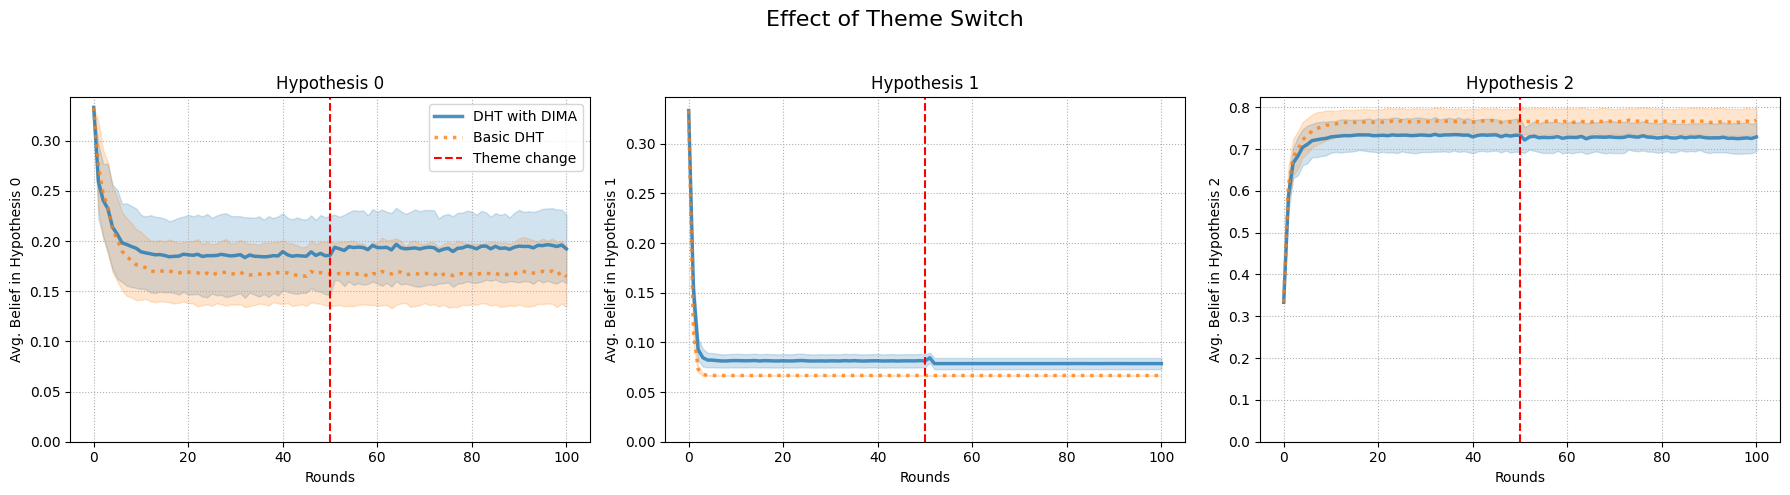

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
from dhtDIMA import DHTwdDIMA
from dht import BasicDHT


def shared_simulation(n_runs = 1):
    dima_traj_list = []
    dht_traj_list = []
    # SHARED SETUP
    for i in range(n_runs):
        N, M, d_feature = 100, 3, 5
        T = 100
        random.seed(10 +1)
        np.random.seed(10 + i)
    
        # Thematic setup
        themes = {"politics": [0, 1], "sports": [2, 3]}
        normative_groups = {
            "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
            "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
        }
    
        # Graph and weight matrix
        G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
        W = nx.to_numpy_array(G)
        W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
    
        # Features and distributions
        agent_features = np.random.rand(N, d_feature)
        distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
    
        # Agent roles
        conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
        remaining_idx = list(set(range(N)) - set(conspirators_idx))
        debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
    
        # DHT with DIMA Simulation
        print("Running DHTwdDIMA simulation...")
        sim_dima = DHTwdDIMA(N, M, G, W, distributions, agent_features, themes, normative_groups,
                             conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=1, seed=10 + i)
        theme_schedule = lambda t: 'sports' if t > 50 else 'politics'
        traj_dima = sim_dima.run(T, theme_schedule)
        dima_traj_list.append(traj_dima)
        
    
        # Basic DHT Simulation
        print("Running Basic DHT simulation...")
        sim_basic = BasicDHT(N, M, W, distributions, conspirators_idx.tolist(), debunkers_idx.tolist(), seed=10 + i)
        traj_basic = sim_basic.run(T)
        dht_traj_list.append(traj_basic)
         
    
    # Convert to numpy arrays for easy averaging
    dima_traj_array = np.array(dima_traj_list)  # shape: (n_runs, T+1, N, M)
    dht_traj_array = np.array(dht_traj_list)    # shape: (n_runs, T+1, N, M)

    idx = [0, 1, 2]
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Use indices from the last run just for "regulars"
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, i in enumerate(idx):
        # Mean over runs, then mean over regular agents
        dima_curve = dima_traj_array[:, :, :, i].mean(axis=(0, 2))
        basic_curve = dht_traj_array[:, :, :, i].mean(axis=(0, 2))
        
        # std
        dima_std = dima_traj_array[:, :, :, i].mean(axis=2).std(axis=0)
        dht_std  = dht_traj_array[:, :, :, i].mean(axis=2).std(axis=0)
        
        rounds = np.arange(len(dima_curve))

        ax = axes[j]
        l1, = ax.plot(rounds, dima_curve, label='DHT with DIMA', linewidth=2.5, alpha=0.8)
        l2, = ax.plot(rounds, basic_curve, label='Basic DHT', linewidth=2.5, linestyle=':', alpha=0.8)
        
        ax.fill_between(rounds, dima_curve - dima_std, dima_curve + dima_std,
                        color=l1.get_color(), alpha=0.2)
        ax.fill_between(rounds, basic_curve - dht_std, basic_curve + dht_std,
                        color=l2.get_color(), alpha=0.2)
               
        ax.axvline(x=50, color='red', linestyle='--', linewidth=1.5, label='Theme change' if j == 0 else "")
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {i}")
        ax.set_title(f"Hypothesis {i}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Effect of Theme Switch", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Effect of Theme Switch_with_std_DimaBeta1.pdf")
    plt.show()

shared_simulation(20)


## 8. Multiple theme switching effect

Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running Basic DHT simulation...
Running DHTwdDIMA simulation...
Running 

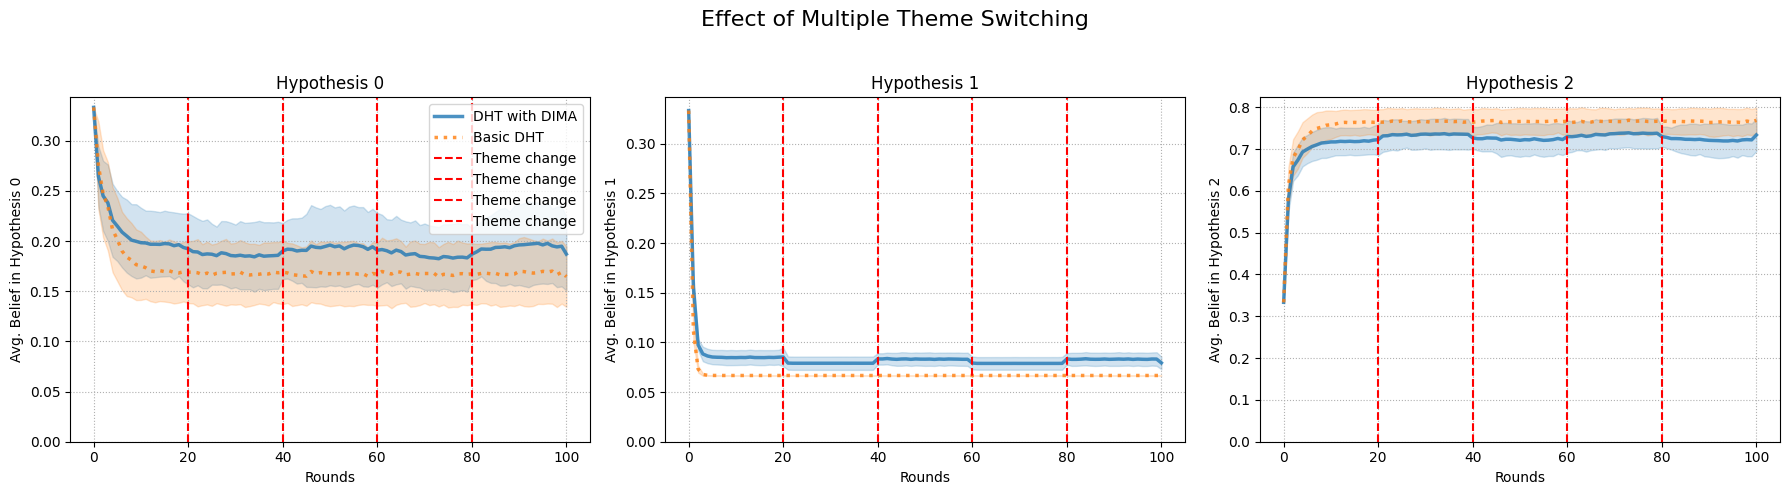

In [2]:
def shared_simulation(n_runs = 1):
    dima_traj_list = []
    dht_traj_list = []
    # SHARED SETUP
    for i in range(n_runs):
        N, M, d_feature = 100, 3, 5
        T = 100
        random.seed(10 +1)
        np.random.seed(10 + i)
    
        # Thematic setup
        themes = {"politics": [0, 1], "sports": [2, 3]}
        normative_groups = {
            "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
            "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
        }
    
        # Graph and weight matrix
        G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
        W = nx.to_numpy_array(G)
        W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
    
        # Features and distributions
        agent_features = np.random.rand(N, d_feature)
        distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
    
        # Agent roles
        conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
        remaining_idx = list(set(range(N)) - set(conspirators_idx))
        debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
    
        # DHT with DIMA Simulation
        print("Running DHTwdDIMA simulation...")
        sim_dima = DHTwdDIMA(N, M, G, W, distributions, agent_features, themes, normative_groups,
                             conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=1, seed=10 + i)
        theme_schedule = lambda t: 'sports' if (t // 20) % 2 == 0 else 'politics'
        traj_dima = sim_dima.run(T, theme_schedule)
        dima_traj_list.append(traj_dima)
        
    
        # Basic DHT Simulation
        print("Running Basic DHT simulation...")
        sim_basic = BasicDHT(N, M, W, distributions, conspirators_idx.tolist(), debunkers_idx.tolist(), seed=10 + i)
        traj_basic = sim_basic.run(T)
        dht_traj_list.append(traj_basic)
         
    
    # Convert to numpy arrays for easy averaging
    dima_traj_array = np.array(dima_traj_list)  # shape: (n_runs, T+1, N, M)
    dht_traj_array = np.array(dht_traj_list)    # shape: (n_runs, T+1, N, M)

    idx = [0, 1, 2]
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Use indices from the last run just for "regulars"
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, i in enumerate(idx):
        # Mean over runs, then mean over regular agents
        dima_curve = dima_traj_array[:, :, :, i].mean(axis=(0, 2))
        basic_curve = dht_traj_array[:, :, :, i].mean(axis=(0, 2))
        
        # std
        dima_std = dima_traj_array[:, :, :, i].mean(axis=2).std(axis=0)
        dht_std  = dht_traj_array[:, :, :, i].mean(axis=2).std(axis=0)

        rounds = np.arange(len(dima_curve))
        ax = axes[j]
        l1, = ax.plot(rounds, dima_curve, label='DHT with DIMA', linewidth=2.5, alpha=0.8)
        l2, = ax.plot(rounds, basic_curve, label='Basic DHT', linewidth=2.5, linestyle=':', alpha=0.8)
        
        ax.fill_between(rounds, dima_curve - dima_std, dima_curve + dima_std,
                        color=l1.get_color(), alpha=0.2)
        ax.fill_between(rounds, basic_curve - dht_std, basic_curve + dht_std,
                        color=l2.get_color(), alpha=0.2)
        ax.axvline(x=20, color='red', linestyle='--', linewidth=1.5, label='Theme change')
        ax.axvline(x=40, color='red', linestyle='--', linewidth=1.5, label='Theme change')
        ax.axvline(x=60, color='red', linestyle='--', linewidth=1.5, label='Theme change' )
        ax.axvline(x=80, color='red', linestyle='--', linewidth=1.5, label='Theme change')
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {i}")
        ax.set_title(f"Hypothesis {i}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Effect of Multiple Theme Switching", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Effect of Multiple Theme Switching_DIMABETA1.pdf")
    plt.show()

shared_simulation(20)


## 9. Effect of neighbourhood size

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


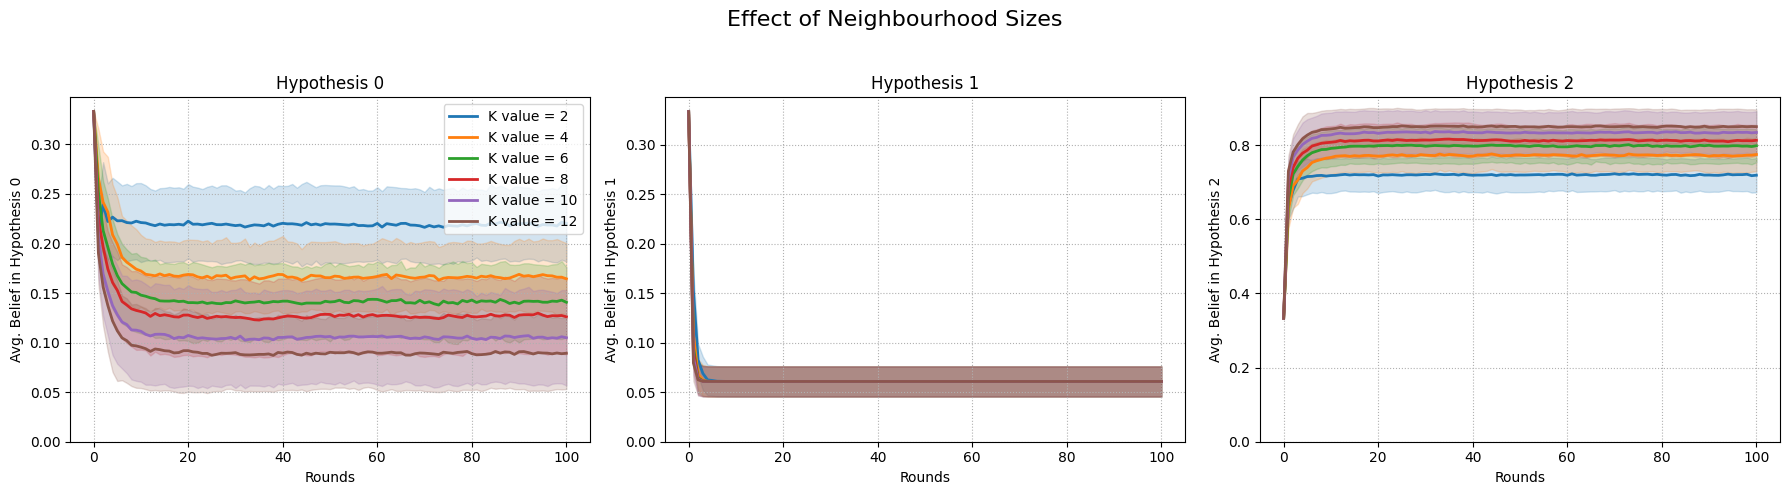

In [11]:
def shared_simulation(n_runs=1):

    k_values  = [2, 4, 6, 8, 10, 12]
    
    # Store: network_dict[n_agents][beta] = dict with per-run data and regulars list
    k_dict = {} 
    
    for k  in k_values :
        run_data = []
        run_regulars = []
           
        for i in range(n_runs):
            print(i)
            N, M, d_feature = 100, 3, 5
            T = 100
            random.seed(10 + i)
            np.random.seed(10 + i)
        
            themes = {"politics": [0, 1], "sports": [2, 3]}
            normative_groups = {
                "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
                "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
            }
            
            G = nx.watts_strogatz_graph(N, k=k, p=0.1, seed=10)
            
            W = nx.to_numpy_array(G)
            W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
        
            agent_features = np.random.rand(N, d_feature)
            distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
        
            conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
            remaining_idx = list(set(range(N)) - set(conspirators_idx))
            debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
            regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))
        

            sim_dima = DHTwdDIMA(
                N, M, G, W, distributions, agent_features, themes, normative_groups,
                conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=0.6, seed=10 + i
            )
            
            traj_dima = sim_dima.run(T)  # shape: (T+1, N, M)
            run_data.append(traj_dima)
            run_regulars.append(regulars)
        
        k_dict[k] = {
            "data": np.array(run_data),       # shape: (n_runs, T+1, N, M)
            "regulars_per_run": run_regulars  # list of lists of indices
        }
    
        # ---- Plotting ----
    idx = [0, 1, 2]  # hypotheses to plot
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Using "regulars" from the last run of last beta for index reference
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, hyp_idx in enumerate(idx):
        ax = axes[j]
        for k in k_dict.keys():
            traj_array = k_dict[k]["data"] # shape: (n_runs, T+1, N, M)
            # mean over runs and over agents (regulars only)
            mean_curve = traj_array[:, :, regulars, hyp_idx].mean(axis=(0, 2))
            std = traj_array[:, :, regulars, hyp_idx].mean(axis=2).std(axis=0)
            rounds = np.arange(len(mean_curve))
            l, = ax.plot(rounds, mean_curve, label=f"K value = {k}", linewidth=2.0)
            ax.fill_between(rounds, mean_curve - std, mean_curve + std,
                        color=l.get_color(), alpha=0.2)
        
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {hyp_idx}")
        ax.set_title(f"Hypothesis {hyp_idx}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Effect of Neighbourhood Sizes", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Effect of Neighbourhood Sizes.pdf")
    plt.show()

shared_simulation(20)
    

## 10. Effects of salience threshold

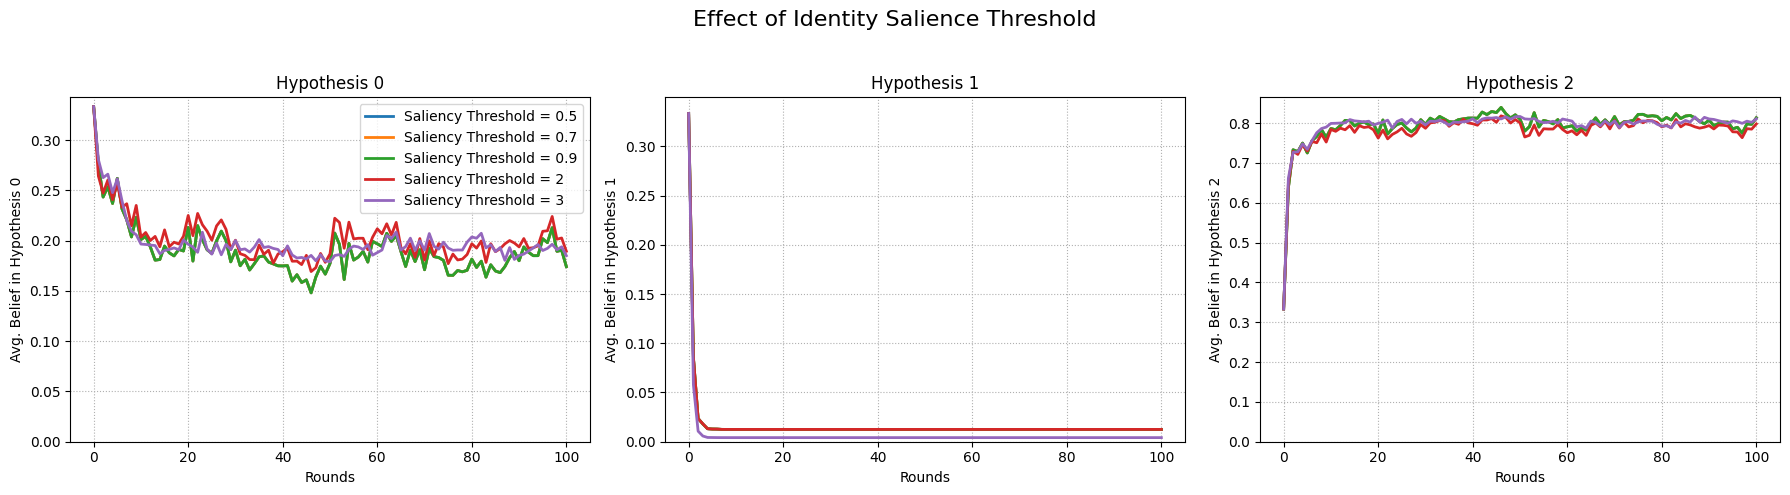

In [8]:
def shared_simulation(n_runs=1):

    Sal_threshold  = [0.5, 0.7, 0.9, 2, 3]
    
    # Store: network_dict[n_agents][beta] = dict with per-run data and regulars list
    Sal_threshold_dict = {} 
    
    for sal  in Sal_threshold :
        run_data = []
        run_regulars = []
           
        for i in range(n_runs):
            N, M, d_feature = 100, 3, 5
            T = 100
            random.seed(10 + i)
            np.random.seed(10 + i)
        
            themes = {"politics": [0, 1], "sports": [2, 3]}
            normative_groups = {
                "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
                "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
            }
            
            G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
            
            W = nx.to_numpy_array(G)
            W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
        
            agent_features = np.random.rand(N, d_feature)
            distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
        
            conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
            remaining_idx = list(set(range(N)) - set(conspirators_idx))
            debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
            regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))
        

            sim_dima = DHTwdDIMA(
                N, M, G, W, distributions, agent_features, themes, normative_groups,
                conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=1, salience_threshold=sal, seed = 10+ i
            )
            
            traj_dima = sim_dima.run(T)  # shape: (T+1, N, M)
            run_data.append(traj_dima)
            run_regulars.append(regulars)
        
        Sal_threshold_dict[sal] = {
            "data": np.array(run_data),       # shape: (n_runs, T+1, N, M)
            "regulars_per_run": run_regulars  # list of lists of indices
        }
    
        # ---- Plotting ----
    idx = [0, 1, 2]  # hypotheses to plot
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Using "regulars" from the last run of last beta for index reference
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, hyp_idx in enumerate(idx):
        ax = axes[j]
        for sal in Sal_threshold_dict.keys():
            traj_array = Sal_threshold_dict[sal]["data"] # shape: (n_runs, T+1, N, M)
            # mean over runs and over agents (regulars only)
            mean_curve = traj_array[:, :, regulars, hyp_idx].mean(axis=(0, 2))
            ax.plot(mean_curve, label=f"Saliency Threshold = {sal}", linewidth=2.0)
        
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {hyp_idx}")
        ax.set_title(f"Hypothesis {hyp_idx}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Effect of Identity Salience Threshold", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Effect of Identity Salience Threshold.pdf")
    plt.show()

shared_simulation()
    

## 11. Effect of signal quality

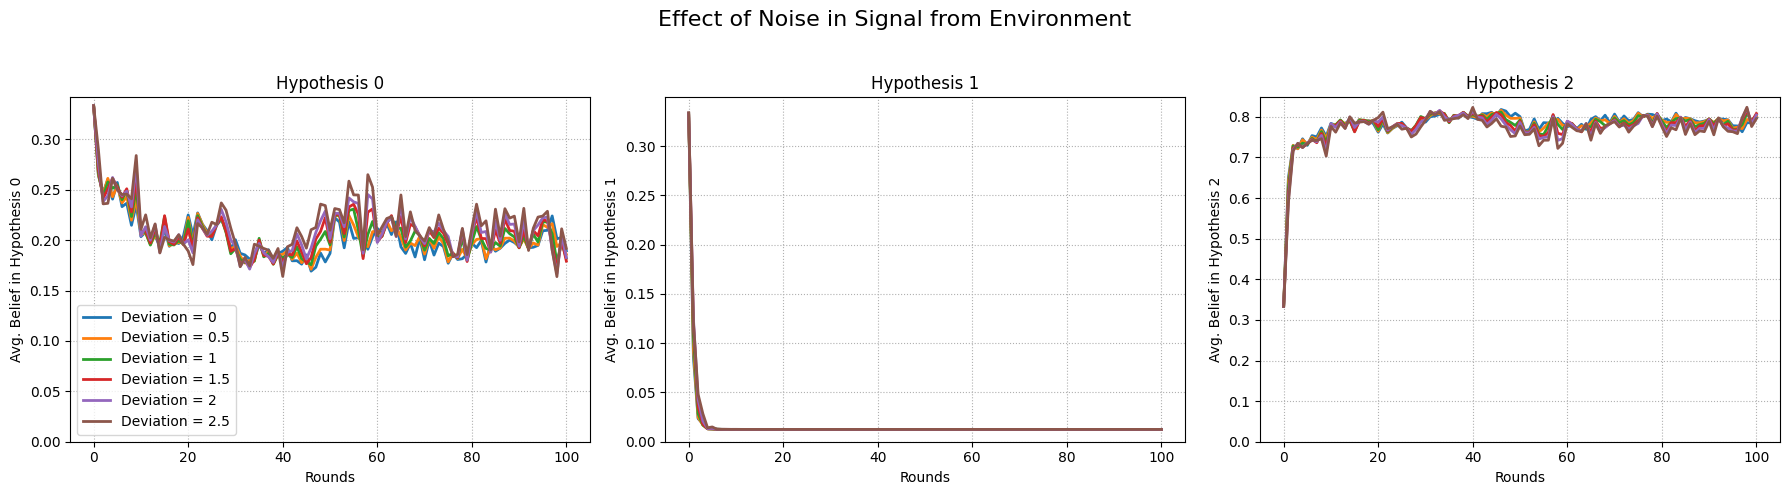

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal
from dhtDIMA import DHTwdDIMA
from dht import BasicDHT



def shared_simulation(n_runs=1):

    dev_thresholds  = [0, 0.5,  1, 1.5, 2, 2.5]
    
    # Store: network_dict[n_agents][beta] = dict with per-run data and regulars list
    dev_threshold_dict = {} 
    
    for dev  in dev_thresholds :
        run_data = []
        run_regulars = []
           
        for i in range(n_runs):
            N, M, d_feature = 100, 3, 5
            T = 100
            random.seed(10 + i)
            np.random.seed(10 + i)
        
            themes = {"politics": [0, 1], "sports": [2, 3]}
            normative_groups = {
                "group_A": np.array([0.1, 0.1, 0.9, 0.9, 0.5]),
                "group_B": np.array([0.9, 0.9, 0.1, 0.1, 0.5])
            }
            
            G = nx.watts_strogatz_graph(N, k=4, p=0.1, seed=10)
            
            W = nx.to_numpy_array(G)
            W = W / (W.sum(axis=1, keepdims=True) + 1e-9)
        
            agent_features = np.random.rand(N, d_feature)
            distributions = [[multivariate_normal(mean=[2*k], cov=[[1]]) for k in range(M)] for _ in range(N)]
        
            conspirators_idx = np.random.choice(N, size=int(0.1*N), replace=False)
            remaining_idx = list(set(range(N)) - set(conspirators_idx))
            debunkers_idx = np.random.choice(remaining_idx, size=int(0.1*N), replace=False)
            regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))
        

            sim_dima = DHTwdDIMA(
                N, M, G, W, distributions, agent_features, themes, normative_groups,
                conspirators_idx.tolist(), debunkers_idx.tolist(), dima_beta=1.0, dev=dev, seed=10+i
            )
            
            traj_dima = sim_dima.run(T)  # shape: (T+1, N, M)
            run_data.append(traj_dima)
            run_regulars.append(regulars)
        
        dev_threshold_dict[dev] = {
            "data": np.array(run_data),       # shape: (n_runs, T+1, N, M)
            "regulars_per_run": run_regulars  # list of lists of indices
        }
    
        # ---- Plotting ----
    idx = [0, 1, 2]  # hypotheses to plot
    fig, axes = plt.subplots(1, len(idx), figsize=(6 * len(idx), 5), sharex=True)
    if len(idx) == 1:
        axes = [axes]

    # Using "regulars" from the last run of last beta for index reference
    regulars = list(set(range(N)) - set(conspirators_idx) - set(debunkers_idx))

    for j, hyp_idx in enumerate(idx):
        ax = axes[j]
        for dev in dev_threshold_dict.keys():
            traj_array = dev_threshold_dict[dev]["data"] # shape: (n_runs, T+1, N, M)
            # mean over runs and over agents (regulars only)
            mean_curve = traj_array[:, :, regulars, hyp_idx].mean(axis=(0, 2))
            ax.plot(mean_curve, label=f"Deviation = {dev}", linewidth=2.0)
        
        ax.set_xlabel("Rounds")
        ax.set_ylabel(f"Avg. Belief in Hypothesis {hyp_idx}")
        ax.set_title(f"Hypothesis {hyp_idx}")
        ax.grid(True, linestyle=':')
        ax.set_ylim(bottom=0)
        if j == 0:
            ax.legend()

    fig.suptitle(f"Effect of Noise in Signal from Environment", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("Effect of Noise in Signal from Environment.pdf")
    plt.show()

shared_simulation()
    